In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.manifold import MDS
from sklearn.ensemble import RandomForestRegressor
import itertools
from random import sample
import math
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# INF554 Assessment: Trees, Bagging and Boosting

In this assessment it is your task to delve deeper into the construction of regression tree-based models.

**Please submit a zip file containing the following to moodle by the 4th November 2024 14.00 (Paris time):**

- your filled out assessment jupyter notebook on the proposed coding tasks and short written answers to the questions;
- all the files necessary to run the jupyter notebook properly.

Make sure to submit a couple of hours ahead of the deadline to ensure that technical difficulties do not cause you to miss the deadline. Late submissions will not be accepted.

Please note that this assessment is *to be completed individually. We will forward detected cases of plagarism to the university,* which in serious cases can have farreaching consequences for you. So, please make sure to submit your own, original solutions to this assessment. 

*Disclaimer:* You will not receive marks for importing the functions that you are asked to code from any library, unless specifically stated in the corresponding task. In this assessment, we ask you to code these methods from scratch in the hope that this will give you a better understanding of them.

## Data set

In this assessment, you will be working with the <a href="https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset">Boston-Housing</a> dataset which originates from a study that aimed to predict the median value of owner-occupied homes in thousands of dollars (medv) in 506 observations from census tracts of the Boston metropolitan area. For this purpose, the followig measures were considered: crime rate by town (crim, $X_1$), proportion of residential land zoned for lots greater than 25,000 sq ft (zne, $X_2$), proportion of nonretail business acres per town (indus, $X_3$), whether the tract bounds river (1) or not (0) (chass, $X_4$), nitrogen oxide concentration in parts per hundred million (nox, $X_5$), average number of rooms in owner units (rm, $X_6$), proportion of owner units built prior to $1940$ (age, $X_7$), weighted distances to five employment centers in the Boston region (dis, $X_8$), index of accessibility to radial highways (rad, $X_9$), full value property tax rate per ten thousands of dollars (tax, $X_{10}$), pupil-teacher ratio by town school district (ptratio, $X_{11}$), black proportion of population (b, $X_{12}$) and proportion of population that is lower status (lstat, $X_{13}$). Thus, we have $13$ predictor variables and the continuous response variable medv, which we denote by $Y$.

In [2]:
df = pd.read_csv("BostonHousing.csv")
print(df.head())
features = df.columns[0:(len(df.columns)-1)]
X = np.array(df[features])
y = np.array(df.medv)


   crim     zn    indus   chas   nox     rm    age   dis     rad   tax   \
0  0.00632  18.0    2.31      0  0.538  6.575  65.2  4.0900     1   296   
1  0.02731   0.0    7.07      0  0.469  6.421  78.9  4.9671     2   242   
2  0.02729   0.0    7.07      0  0.469  7.185  61.1  4.9671     2   242   
3  0.03237   0.0    2.18      0  0.458  6.998  45.8  6.0622     3   222   
4  0.06905   0.0    2.18      0  0.458  7.147  54.2  6.0622     3   222   

   ptratio    b      lstat   medv  
0      15.3  396.90    4.98  24.0  
1      17.8  396.90    9.14  21.6  
2      17.8  392.83    4.03  34.7  
3      18.7  394.63    2.94  33.4  
4      18.7  396.90    5.33  36.2  


## A. Trees

In this section, we will learn how to construct a regression tree. Suppose we are given a training sample of $N$ individuals, $\left\lbrace \left(x_i,y_i \right) \right\rbrace_{1\leq i\leq N}$, on which $d$ predictor variables are measured, $x_i\in\mathbb{R}^d$, and one real value is associated with each one, $y_i\in\mathbb{R}$. Classic regression tree methods consist of sequentially, and greedily, partitioning the predictor space $\mathbb{R}^d$ into disjoint sets or *nodes* by imposing certain conditions on the predictor variables. The usual splitting criterion is to take the split that produces descendant nodes with smaller and smaller prediction errors. The process of partitioning finishes when a stopping criterion is satisfied. Then, leaf nodes are labeled with a numerical value. Commonly, a leaf node is labeled with a constant, such as the mean or the median variable response in the individuals that have fallen into the node. Once the tree is built, the prediction of future unlabeled data is done in a deterministic way. Given a new observation, starting from the root node, it will end up in a leaf node, depending on the values the predictor variables take, and its predicted value will be the one attached to that leaf node. Because of the construction of regression trees, normalization of the data is not required.

Specifically, we will focus on binary regression trees with univariate splits. Given a node $t$, the proposed splitting for continuous features is to generate the following left and right child nodes: $t_L = \left\lbrace u\in t: x_{ju} \leq b_t\right\rbrace$ and $t_R = \left\lbrace u\in t: x_{ju} > b_t\right\rbrace$, where cutpoint $b_t$ is the halfway point between two consecutive data values of feature $x_j$. Assuming that these values are ordered from lowest to highest, at most $N-1$ different splits can be done. As said, the best split will be the one that best-separates the objects in the training sample by their response variable values, that is, that produces the maximum error reduction of objects associated with resultant nodes. In the following, we study different quantitative ways to measure the error within a node.

### Node error measures

Given node $t$ and a numerical value $c_t$ that is used as a constant prediction at $t$, an error measure $e(t,c_t)$ can be defined by:

**mean square error:** $\dfrac{1}{|\mathcal{I}(t)|}\sum\limits_{i\in \mathcal{I}(t)} \left( y_i - c_t\right)^2$ 

**mean absolute error:** $\dfrac{1}{|\mathcal{I}(t)|}\sum\limits_{i\in \mathcal{I}(t)} | y_i - c_t|$ 

where $\mathcal{I}(t)$ is the set of samples fallen in node $t$. The mean or the median of the response variable values over $\mathcal{I}(t)$ are commonly used as $c_t$ value. The same choice for $c_t$ is usually made for all the nodes.

>**Task 1: (2 Points)** Complete the below functions to define the two node error measures above.

In [3]:
def mean_square_error(y_t,c_t):
    """
    Inputs:
        y_t (|I(t)|-dimensional vector): response variable values at a given node t
        c_t (string): prediction label at node t, {'mean','median'} 
    Outputs:
        e_tc (float): mean square error at node t using label c
    """
    # insert your code here 
    if c_t == 'mean':
        c = np.mean(y_t)
        e_tc = y_t - c
        e_tc = np.sum(e_tc**2)/len(y_t)
        
    elif c_t == 'median':
        c = np.median(y_t)
        e_tc = y_t - c
        e_tc = np.sum(e_tc**2)/len(y_t)
    return e_tc

def mean_absolute_error(y_t,c_t):
    """
    Inputs:
        y_t (|I(t)|-dimensional vector): response variable values at a given node t
        c_t (string): prediction at node t, {'mean','median'} 
    Outputs:
        e_tc (float): mean absolute error at node t using label c
    """
    # insert your code here 
    if c_t == 'mean':
        c = np.mean(y_t)
        e_tc = y_t - c
        e_tc = np.sum(np.abs(e_tc))/len(y_t)
        
    elif c_t == 'median':
        c = np.median(y_t)
        e_tc = y_t - c
        e_tc = np.sum(np.abs(e_tc))/len(y_t)
    return e_tc

print('The mean square error using the mean and the median for the whole dataset are, respectively,')
print(np.around(mean_square_error(y,'mean'),3))
print('and')
print(np.around(mean_square_error(y,'median'),3))
print('The mean absolute error using the mean and the median for the whole dataset are, respectively,')
print(np.around(mean_absolute_error(y,'mean'),3))
print('and')
print(np.around(mean_absolute_error(y,'median'),3))

The mean square error using the mean and the median for the whole dataset are, respectively,
84.42
and
86.196
The mean absolute error using the mean and the median for the whole dataset are, respectively,
6.647
and
6.531


Since the fundamental idea is to produce more and more accurate nodes, the selection of the split of a parent node will be done in terms of the information gain, which measures somehow the prediction accuracy gained when a node is split into child nodes. In what follows, this concept is formally defined.

### Information gain

Let $s\in S$ be a candidate split of data points assigned to a given node $t$, and let $e(t,c_t)$ be a node error measure. The information gain of $s$ relative to node $t$ is defined as the average reduction of prediction error obtained by splitting the observations within node $t$ according to $s$

$$ G(t,s) = e(t,c_t) - \left(q_L(s) * e\left(t_L(s),c_{t_L}(s)\right) + q_R(s) * e\left(t_R(s),c_{t_R}(s)\right)\right)$$

where $e(t, c_t)$ denotes the error made on all predictions at node $t;$ $t_L(s)$ and $ t_R(s)$ are the left and right child nodes originating from the splitting of node $t$ produced by $s$, $c_{t_L}(s), c_{t_R}(s)$ the respective prediction labels, and $q_L(s), q_R(s)$ the proportion of observations (within node $t$) that become elements from new nodes $t_L(s), t_R(s)$. This definition could be generalized for non-binary splitting.

Let $\Omega_c$ be the set of current leaf nodes that can be potentially split. Then, the selected split over $\Omega_c$ will be the one that maximizes the corresponding information gain:

$$ G(t^\ast, s^\ast) = \max\limits_{t\in\Omega_c,\,s\in S}\left\lbrace G(t,s) \right\rbrace$$

>**Task 2: (9 Points)** Complete the below function following the steps within it in order to produce the first split in a binary regression tree for all the observations of the Boston-Housing data set and for both node error measures. Consider just crim as the predictor. 

In [4]:
feature = np.array(X[:,0])
target = y

def first_split(feature, target, node_error_measure, c_t):
    """
    Inputs:
        feature (N-dimensional vector): feature values
        target (N-dimensional vector): target values
        node_error_measure (function): mean square error or mean absolute error functions
        c_t (string): prediction label at node t, {'mean','median'} 
    Outputs:
        error_parent_node (float): error measure of parent node t
        error_left_child_node (float): error measure of left child node t_L
        error_right_child_node (float): error measure of right child node t_R
        best_cutpoint (float): feature value from which to split b_t
    """
    # Step 1: Compute the list of candidate cutpoints
    # insert your code here
    cutpoints = np.sort(feature)
    b_t = (cutpoints[1:] + cutpoints[:-1])/2
    
    # Step 2: Compute the information gain for each candidate cutpoint
    # insert your code here
    G = []
    error_parent_node = node_error_measure(target,c_t) 
    for s in b_t:
        t_L = target[feature <= s]
        t_R = target[feature > s]
        e_L = node_error_measure(t_L,c_t)
        e_R = node_error_measure(t_R,c_t)
        q_L = len(t_L)/len(target)
        q_R = len(t_R)/len(target)
        G.append(error_parent_node - (q_L*e_L + q_R*e_R))
        
    
    # Step 3: Obtain the first split according to the maximum information gain
    # insert your code here
    best_cutpoint = b_t[np.argmax(G)]
    t_R = target[feature > best_cutpoint]
    t_L = target[feature <= best_cutpoint]
    error_right_child_node = node_error_measure(t_R,c_t)
    error_left_child_node = node_error_measure(t_L,c_t)
    
    print('Node error measure used is:', node_error_measure.__name__)
    print('with prediction based on:', c_t)
    print('Error at root node =', np.around(error_parent_node,3))
    print('The left branch is','X <=', np.around(best_cutpoint,3), 'with error =', np.around(error_left_child_node,3))
    print('The right branch is','X >', np.around(best_cutpoint,3), 'with error =', np.around(error_right_child_node,3))
    print('\n')
    
    return error_parent_node, error_left_child_node, error_right_child_node, best_cutpoint

first_split(feature, target, mean_square_error, 'mean');
first_split(feature, target, mean_square_error, 'median');
first_split(feature, target, mean_absolute_error, 'mean');
first_split(feature, target, mean_absolute_error, 'median');

Node error measure used is: mean_square_error
with prediction based on: mean
Error at root node = 84.42
The left branch is X <= 6.686 with error = 71.717
The right branch is X > 6.686 with error = 50.822


Node error measure used is: mean_square_error
with prediction based on: median
Error at root node = 86.196
The left branch is X <= 6.597 with error = 75.828
The right branch is X > 6.597 with error = 51.6


Node error measure used is: mean_absolute_error
with prediction based on: mean
Error at root node = 6.647
The left branch is X <= 5.848 with error = 6.147
The right branch is X > 5.848 with error = 4.665


Node error measure used is: mean_absolute_error
with prediction based on: median
Error at root node = 6.531
The left branch is X <= 5.848 with error = 5.807
The right branch is X > 5.848 with error = 4.472




>**Question 1: (1 Points)** Explain in one sentence the link between the outputs obtained from Tasks 1 and 2.
>
>*Answer* (Include your answer here)

>The outputs from Tasks 1 and 2 demonstrate how different error measures (mean square error and mean absolute error) and prediction labels (mean and median) affect the evaluation of node splits and the corresponding error reductions in decision tree splitting.


>**Task 3: (3 Points)** Use <a href="https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html">DecisionTreeRegressor</a>  from the scikit-learn package to learn the first split for both mean square error and mean absolute error using the mean and the median as predictions, respectively.  Consider just crim as the predictor again. Are the results consistent with the output obtained in Task 2?

[Text(0.5, 0.75, 'x[0] <= 5.848\nabsolute_error = 6.531\nsamples = 506\nvalue = 21.2'),
 Text(0.25, 0.25, 'absolute_error = 5.807\nsamples = 412\nvalue = 22.45'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'absolute_error = 4.472\nsamples = 94\nvalue = 13.05'),
 Text(0.625, 0.5, '  False')]

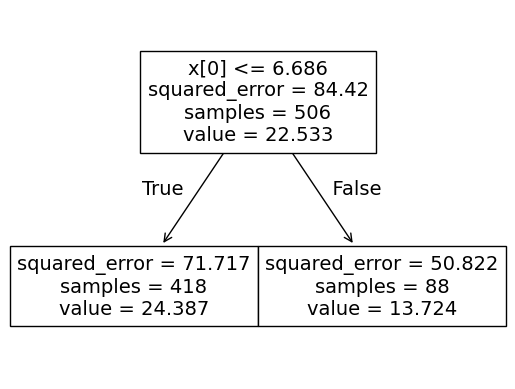

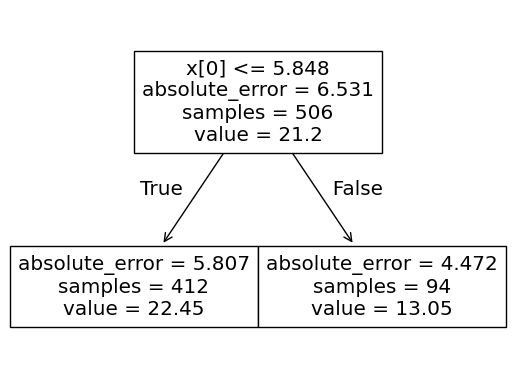

In [5]:
new_feature = feature.reshape(-1, 1)

# squared_error for the mean squared error
clf_mse_mean = DecisionTreeRegressor(criterion="squared_error", max_depth=1)
clf_mse_mean.fit(new_feature, target)

plt.figure()
plot_tree(clf_mse_mean)

# absolute_error for the mean absolute error
clf_mae_median = DecisionTreeRegressor(criterion="absolute_error", max_depth=1)
clf_mae_median.fit(new_feature, target)

plt.figure()
plot_tree(clf_mae_median)

>Base on the result we obtain above, we see that we get the same result as task 2.

## B. Bagging Trees

Single decision trees are known to suffer from high variance. This means that if two decision trees are grown over two disjoint subsamples from the training data, they may lead to quite different results. A general procedure for reducing the variance of any learning method is bootstrap aggregating or bagging. *A bootstrap is a set of observations extracted randomly from the original sample, with replacement and of the same size as the original sample.* Bagging is a methodology that generates multiple bootstrap samples and the regressor is trained with each one and then the outcomes are aggregated. 

>**Question 2: (3 Points)** Compute the probability that a given observation in a data set of size N is part of a bootstrap sample, and study the limit of this probability as N tends to infinity.
>
>*Answer* (Include your answer here)

> The probability that a given observation is *not* selected in one draw for a bootstrap sample is $1 - \frac{1}{N}$. Since a bootstrap sample consists of $N$ draws with replacement, the probability that the observation is not selected in any of the $N$ draws is $\left(1 - \frac{1}{N}\right)^N$. Therefore, the probability that the observation is selected at least once is:
> $$
> P(\text{selected}) = 1 - \left(1 - \frac{1}{N}\right)^N
> $$
> As $N \to \infty$, using the limit definition of the exponential function:
> $$
> \lim_{N \to \infty} \left(1 - \frac{1}{N}\right)^N = \frac{1}{e}
> $$
> Thus, the probability that a given observation is part of the bootstrap sample approaches:
> $$
> P(\text{selected}) = 1 - \frac{1}{e} \approx 0.632
> $$


A special case of bagging is the well-known Random Forest model. In the Random Forest model, B decision trees are grown over B bootstrapped training samples and the prediction is the average taditionally, at each time the split ata  node in a given decision tree is considered, a sample of $m$ predictor variables is chosen randomly among the $d$ initial ones. This randomization helps to decorrelate the trees that are being generated.

An advantage of bagging is that all the trees are grown independently, and hence they can be fit in parallel.

>**Task 4: (5 Points)** Implement the Random Forest regressor using B = 10 and $m=\lceil \log_2{d} \rceil$, where np.random.choice might be helpful. You can use <a href="https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html">DecisionTreeRegressor</a> from scikit-learn package together with the fit and predict functions.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

def train_and_predict_RF(B, m, X_train, y_train, X_test):
    """
    Inputs:
        B (int): number of trees
        m (int): number of features to be randomly chosen at each split in the tree
        X_train (Nxp matrix): training data
        y_train (N vector): response values
        X_test (N_test x p matrix): test data to be predicted
    Outputs:
        y_train_pred (N_train x B matrix): prediction for each individual in the training data as a function of B
        y_test_pred (N_test x B matrix): prediction for each individual in the test data as a function of B
    """
    # insert your code here
    n,p = X_train.shape
    n_test, p_test = X_test.shape
    y_train_pred = np.zeros(shape =(n,B))
    y_test_pred = np.zeros(shape=(n_test,B))
    
    train_pred = np.zeros(n)
    test_pred = np.zeros(n_test)
    for i in range(B):
        # Bootstrap sampling
        bootstrap_indices = np.random.choice(n,n, replace=True)
        X_bootstrap = X_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]
        
        # Random feature selection for each tree
        feature_index = np.random.choice(p,m, replace=False)
        X_bootstrap_subset = X_bootstrap[:,feature_index]
        
        # Train a DT on Bootstrap sample
        DF = DecisionTreeRegressor(criterion='squared_error',max_features=m)
        DF.fit(X_bootstrap_subset, y_bootstrap)
        
        # Prediction
        X_train_subset = X_train[:, feature_index]
        X_test_subset = X_test[:, feature_index]
        
        train_pred += DF.predict(X_train_subset)
        test_pred += DF.predict(X_test_subset)
        
        y_train_pred[:,i] += train_pred / (i+1)
        y_test_pred[:,i] += test_pred / (i+1)
        
        
    return y_train_pred, y_test_pred

np.random.seed(1)
B = 10
y_train_pred_RF, y_test_pred_RF = train_and_predict_RF(B, int(np.round(np.log2(13))), X_train, y_train, X_test)
mse_test_10 = np.sum((y_test-y_test_pred_RF[:,B-1])**2)/len(y_test)
print('The RF mse over the test sample is:', mse_test_10)

The RF mse over the test sample is: 24.347242841922515


>**Task 5: (2 Points)** Plot the evolution of the mean square error of both the train and test sample as a function of the number of trees $B\in \{1,\ldots, 10\}$ of the Random Forest obtained in Task 4. Include the performance of one single full decision tree obtained from <a href="https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html">DecisionTreeRegressor</a> routine, using the mean square error as node error measure, the mean as node prediction and the minimum number of samples required to split a node equal to $10$.

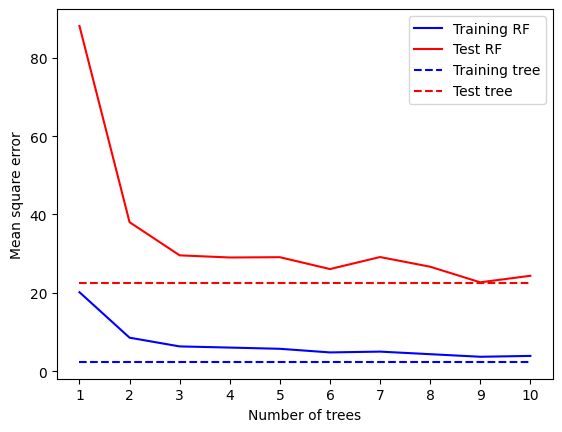

In [7]:
# train and test mse for RF
mse_train_RF = np.zeros(B)
mse_test_RF = np.zeros(B)
# insert your code here
for i in range(1, B+1):
    mse_train_RF[i-1] = np.sum((y_train-y_train_pred_RF[:,i-1])**2)/len(y_train)
    mse_test_RF[i-1] = np.sum((y_test-y_test_pred_RF[:,i-1])**2)/len(y_test)


# train and test mse for tree
# insert your code here
tree_model = DecisionTreeRegressor(criterion='squared_error', min_samples_split=10, random_state=1)
tree_model.fit(X_train, y_train)

y_train_pred_tree = tree_model.predict(X_train)
y_test_pred_tree = tree_model.predict(X_test)

mse_train_tree = np.sum((y_train_pred_tree - y_train) ** 2) / len(y_train)
mse_test_tree = np.sum((y_test_pred_tree - y_test) ** 2) / len(y_test)


plt.figure()
plt.plot(np.arange(1,B+1),mse_train_RF, 'b-', label="Training RF")
plt.plot(np.arange(1,B+1),mse_test_RF, 'r-', label="Test RF")
plt.plot(np.arange(1,B+1),np.repeat(mse_train_tree,B), 'b--', label="Training tree")
plt.plot(np.arange(1,B+1),np.repeat(mse_test_tree,B), 'r--', label="Test tree")
plt.xticks(np.arange(1,B+1))
plt.xlabel('Number of trees')
plt.ylabel('Mean square error')
plt.legend()
plt.show()

>**Question 3: (2 Points)** Compare the performance of the random forest regressor and the single full decision tree in terms of goodness-of-fit and generalization power in the following cases, and explain briefly why this might be happening:
>- when $B=1$.
>- when $B$ becomes larger and larger.
>  
>*Answer* (Include your answer here)
>
> - **When $B=1$**: The random forest regressor behaves like a single decision tree. From the plot, we observe that the test error (Test RF) is initially very high, similar to the test error of a single tree (Test tree). This suggests poor generalization power, likely due to the high variance of the single tree model.
> 
> - **When $B$ becomes larger and larger**: As $B$ increases, the random forest regressor significantly reduces test error (Test RF) compared to a single tree, indicating better generalization. The training error (Training RF) also stabilizes, showing reduced overfitting. This improvement occurs because bagging reduces variance by averaging multiple trees, which leads to a more stable and robust model.

In the following, we will study a proximity measure for a given pair of observations designed for Random Forest. Let $i$ and $j$ be two observations, the similarity measure between both, $\delta_{ij}$, is the proportion of trees in the RF in which $i$ and $j$ are placed in the same leaf node. This proximity measure is usually calculated during the construction of RF by making use of the OOB observations. Then, the proportion is not calculated using all B trees but only using the number of trees where observations $i$ and $j$ are in the OOB observations.

>**Task 6: (6 Points)** Complete the function below in order to compute the Random Forest similarity measure for each pair of observations at the same time of model fitting.  You can use <a href="https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html">DecisionTreeRegressor</a> from scikit-learn package, where you specify the number of features to be randomly chosen at each split in the tree and the minimum number of samples in a node to perform a split, together with the fit and predict functions.

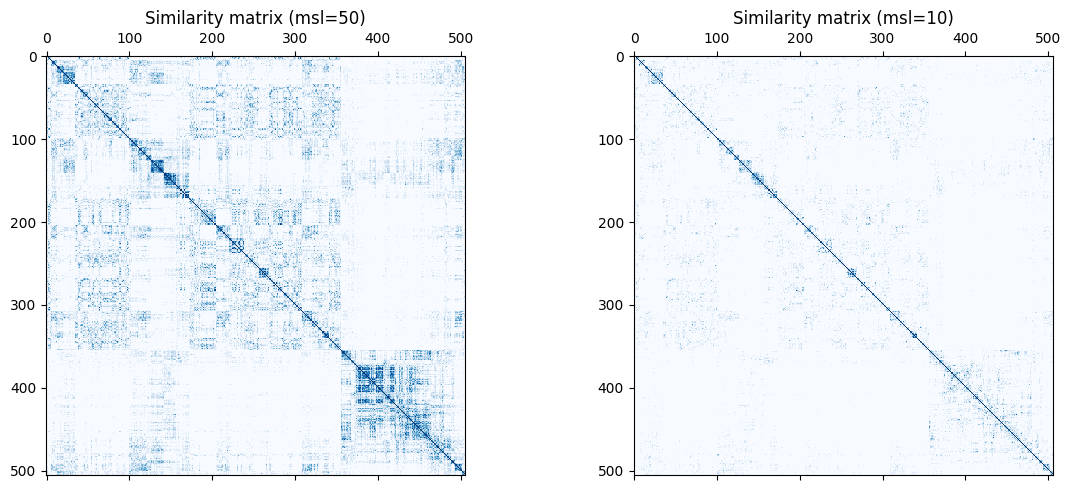

The similarity between observations 9 and 10 with msl=50 is: 0.5882352941176471
The similarity between observations 9 and 10 with msl=10 is: 0.17647058823529413


In [8]:
def similarity_measure_RF(B, m, msl, X, y):
    """
    Inputs:
        B (int): number of trees
        m (int): number of features to be randomly chosen at each split in the tree
        msl (int): mininum number of samples in a node to perform a split
        X (Nxd matrix): feature values
        y (N vector): response values
    Outputs:
        delta (NxN matrix): similarity matrix
        y_pred (N vector): prediction for each individual in the data
    """
    #insert your code here
    N, d = X.shape

    y_pred_sum = np.zeros(N)
    delta = np.zeros((N, N))
    oob_matrix = np.zeros((N, N))  # oob[i, j] = number of trees in RF where i, j are both out of the bag

    for i in range(B):
        indices = np.arange(N)
        bootstrap_indices = np.random.choice(indices, size=N, replace=True)
        oob_indices = np.setdiff1d(indices, bootstrap_indices)

        X_bootstrap = X[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]

        tree_i = DecisionTreeRegressor(criterion="squared_error", max_features=m, min_samples_split=msl)
        tree_i.fit(X_bootstrap, y_bootstrap)

        # Predict on OOB samples
        X_oob = X[oob_indices]
        pred_oob = tree_i.predict(X_oob)

        for j in range(len(oob_indices)):
            for k in range(j + 1, len(oob_indices)):
                idx_j = oob_indices[j]
                idx_k = oob_indices[k]

                oob_matrix[idx_j, idx_k] += 1
                oob_matrix[idx_k, idx_j] = oob_matrix[idx_j, idx_k]

                if pred_oob[j] == pred_oob[k]:
                    delta[idx_j, idx_k] += 1
                    delta[idx_k, idx_j] = delta[idx_j, idx_k]

        # Accumulate predictions for all trees
        y_pred_sum += tree_i.predict(X)

    # Calculate final predictions by averaging over all trees
    y_pred = y_pred_sum / B

    # Normalize delta by the number of trees where both were OOB
    for j in range(N):
        delta[j, j] = 1  # An observation is perfectly similar to itself
        for k in range(j + 1, N):
            if oob_matrix[j, k] > 0:
                delta[j, k] /= oob_matrix[j, k]
                delta[k, j] = delta[j, k]

    return delta, y_pred

np.random.seed(1)
delta_50, y_pred_50 = similarity_measure_RF(100, int(np.round(np.log2(8))), 50, X, y)
delta_10, y_pred_10 = similarity_measure_RF(100, int(np.round(np.log2(8))), 10, X, y)

fig, plts = plt.subplots(1,2, figsize=(12,5)) 
fig1=plts[0].matshow(delta_50, cmap='Blues')
plts[0].set_title('Similarity matrix (msl=50)')
fig2=plts[1].matshow(delta_10, cmap='Blues')
plts[1].set_title('Similarity matrix (msl=10)')
plt.tight_layout() 
plt.show()

print('The similarity between observations 9 and 10 with msl=50 is:', delta_50[8,9]) 
print('The similarity between observations 9 and 10 with msl=10 is:', delta_10[8,9]) 

>**Question 4: (1 Points)** How can you explain the different intensities obtained with both heatmaps in Task 6?
>
>*Answer* (Include your answer here)
>
> With a higher value of $msl$, the tree stops splitting sooner, leading to a smaller number of leaf nodes. This means there are fewer categories to classify the data into, increasing the chance that two out-of-bag observations will end up in the same leaf. As a result, the similarity scores are greater for $msl = 50$ compared to $msl = 10$ because fewer splits cause more observations to share the same leaves.


Next, we will use the data proximity matrix provided by Random Forests in order to do some data visualization via MultiDimensional Scaling (MDS). MDS uses as input any dissimilarity matrix. The Random Forests dissimilarity matrix is defined as $\bar{\delta}_{ij} = \sqrt{1-\delta_{ij}},\,\, i,j=1,\ldots,N$.

>**Task 7: (3 Points)** Apply multidimensional scaling to the dissimilarity matrix using <a href="https://scikit-learn.org/dev/modules/generated/sklearn.manifold.MDS.html">MDS</a> from scikit-learn package. Then, plot the first two coordinates as a function of both the value of the response variable and the predicted values obtained in Task 6. 

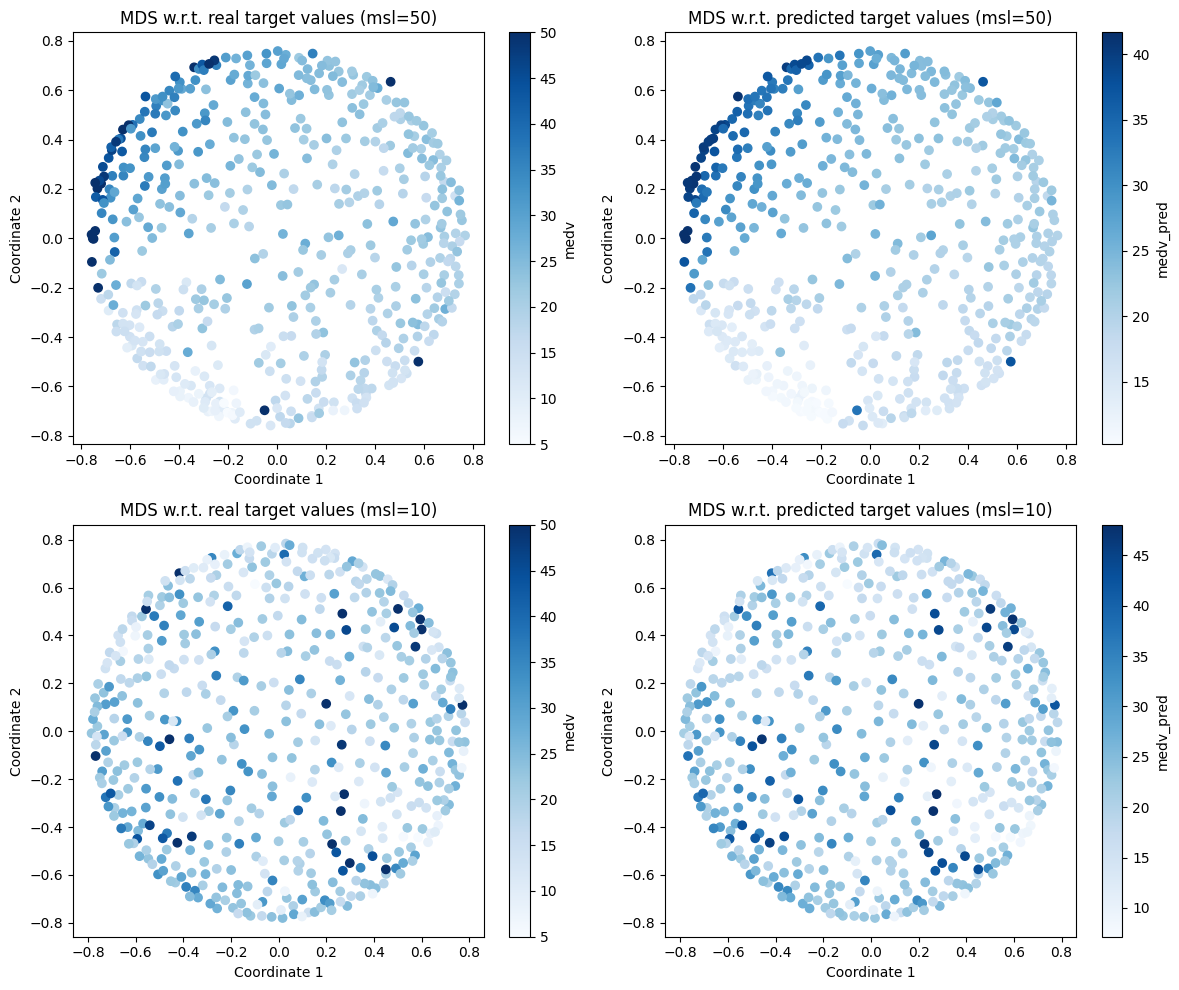

In [9]:
np.random.seed(2)
# insert your code here
delta_bar_50 = np.sqrt(1 - delta_50)
delta_bar_10 = np.sqrt(1 - delta_10)
mds = MDS(n_components=2, dissimilarity="precomputed")
coordinates_MDS_50 = mds.fit_transform(delta_bar_50)
coordinates_MDS_10 = mds.fit_transform(delta_bar_10)


fig, plts = plt.subplots(2,2, figsize=(12,10)) 

fig1=plts[0,0].scatter(coordinates_MDS_50[:,0], coordinates_MDS_50[:,1], c=y, cmap='Blues')
plts[0,0].set_xlabel('Coordinate 1')
plts[0,0].set_ylabel('Coordinate 2')
plts[0,0].set_title('MDS w.r.t. real target values (msl=50)')
fig.colorbar(fig1, ax=plts[0,0], label='medv')

fig2=plts[0,1].scatter(coordinates_MDS_50[:,0], coordinates_MDS_50[:,1], c=y_pred_50, cmap='Blues')
plts[0,1].set_xlabel('Coordinate 1')
plts[0,1].set_ylabel('Coordinate 2')
plts[0,1].set_title('MDS w.r.t. predicted target values (msl=50)')
fig.colorbar(fig2, ax=plts[0,1], label='medv_pred')

fig3=plts[1,0].scatter(coordinates_MDS_10[:,0], coordinates_MDS_10[:,1], c=y, cmap='Blues')
plts[1,0].set_xlabel('Coordinate 1')
plts[1,0].set_ylabel('Coordinate 2')
plts[1,0].set_title('MDS w.r.t. real target values (msl=10)')
fig.colorbar(fig3, ax=plts[1,0], label='medv')

fig4=plts[1,1].scatter(coordinates_MDS_10[:,0], coordinates_MDS_10[:,1], c=y_pred_10, cmap='Blues')
plts[1,1].set_xlabel('Coordinate 1')
plts[1,1].set_ylabel('Coordinate 2')
plts[1,1].set_title('MDS w.r.t. predicted target values (msl=10)')
fig.colorbar(fig4, ax=plts[1,1], label='medv_pred')

plt.tight_layout() 
plt.show()

>**Question 5: (3 Points)** Compare the outputs observed in Task 6 for msl=50 and msl=10, in terms of:
>- the  structure according to the actual target values;
>- the goodness-of-fit according to predicted target values.
>
>*Answer* (Include your answer here)

>### STRUCTURE
>
>In the MDS plot for $msl = 50$, higher similarity values result in shorter average distances between points. This causes the points to form tighter clusters, with their arrangement reflecting their target values. Specifically, the upper left corner of the plot shows the highest target values, while intermediate values appear in the upper right, and the lowest values are seen in the lower section. On the other hand, for $msl = 10$, the lower similarity values cause the points to be more randomly distributed, making it difficult to observe any clear relationship between the points' positions and their target values.
>
>### GOODNESS-OF-FIT
>
>With $msl = 50$, fewer leaf nodes are created, so observations with similar but not identical targets often share the same leaf. This clustering in the MDS plot corresponds to what we expect for generalization, indicating a better fit. It's important to note that these predictions are based on training data, which means lower $msl$ values may lead to overfitting and poor generalization on test data. However, within the training data, the predictions for $msl = 10$ closely match those for $msl = 50$, though subtle differences remain.


In the following, we will study a method to compute feature contributions for model predictions based on the <a href="https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf">Shapley value</a>, a measure taken from cooperative game theory. This method requires retraining the model on all feature subsets $S\subseteq F$, where $F$ is the set of all features. It assigns an importance value to each feature that represents the effect on the model prediction including that feature. To compute this effect, a model $f_{S\cup j}$ is trained with that feature present, and another model $f_S$ is trained with the feature withheld. Then, predictions from the two models are compared on the current input $f_{S\cup i} (x^i_{S\cup j}) - f_S(x^i_S)$, where $x^i_S$ represents the values of the input features in the set $S$ for observation $x^i$. Since the effect of withholding a feature depends on other features in the model, the preceding differences are computed for all possible subsets $ S\subseteq F \backslash j$. The Shapley values $\Phi_j(x^i)$ are then computed and used as feature attributions. They are a weighted average of all possible differences:

$$\Phi_j(x^i) = \sum\limits_{S\subseteq F\backslash j} \dfrac{|S|!\left(|F|-|S|-1\right)!}{|F|!}\left[ f_{S\cup j}\left(x^i_{S\cup j}\right)-f_S\left(x^i_S\right)\right].$$

Then, one could define the importance of a given feature $j$ as the mean of its Shapley values over the whole dataset, that is,

$$I_j = \frac{1}{n}\sum\limits_{i=1}^n |\Phi_j(x^i)|.$$

>**Question 6: (1 Points)** An exact computation of the Shapley values is computationally expensive. How many models one would have to generate to obtain the Shapley values of all the features in our example, i.e., the Boston-Housing dataset?
>
>*Answer* (Include your answer here)

> In our dataset, we have $|F| = 13$ features, so we need to train $2^{|F|} = 2^{13} = 8192$ models.

Due to the computational effort required to obtain the Shapley values, we will work with an approximation. Instead of computing the models for all the possible subsets of features $S\subseteq F$, we will sample a small collection of them, namely, $k$, thus the sum in $\Phi_j(x^i)$ will consist of just $k$ terms. In the following, we will refer to $k$ as the approximation size of the Shapley values. 

>**Task 8: (7 Points)** Complete the function below in order to compute the Shapley value of all the predictors and all the individuals in the training set, and the corresponding feature importance. Make use of the <a href="https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html">RandomForestRegressor</a> routine from scikit-learn package together with the fit and predict functions. Use the default parameters and random_state=0. The function "sample" from package "random" might be useful.

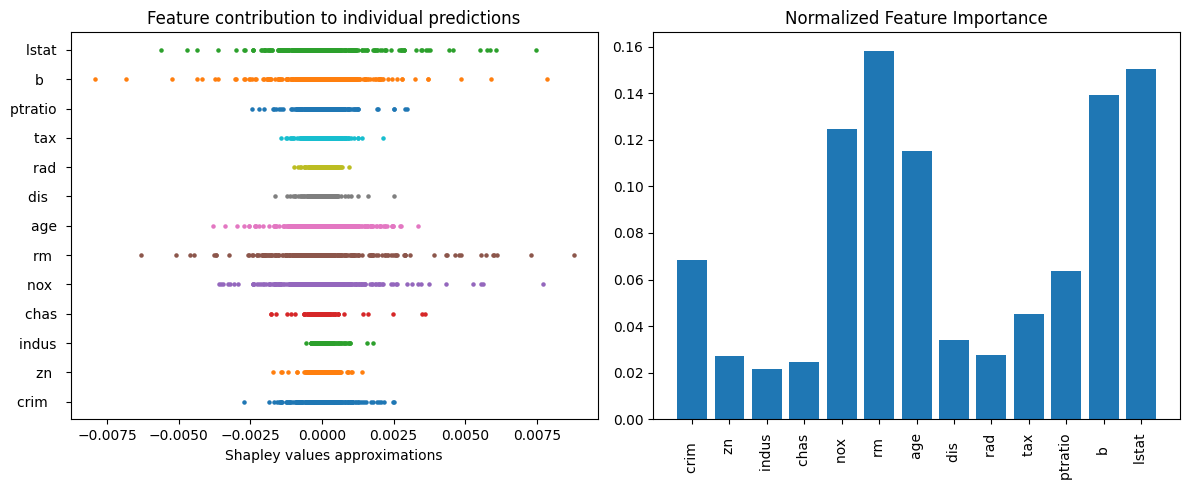

The most important feature is rm  


In [10]:
def shapley_values_RF(X, y, k):
    """
    Inputs:
        X (Nxd matrix): feature data
        y (N vector): response values
        k (int): approximation size
    Outputs:
        Phi (N x p vector): Shapley value per observation per predictor 
        I (p vector): Shapley variable importance
    """
    clf = RandomForestRegressor(random_state=0)
    #insert your code here
    n, d = X.shape
    Phi = np.zeros((n, d))
    I = np.zeros(d)

    for j in range(d):
        # Exclude feature j and prepare for all other combinations
        F_minus_j = list(range(d))
        F_minus_j.remove(j)  # Remove feature index j
        subsets = list(itertools.chain.from_iterable(
            itertools.combinations(F_minus_j, r) for r in range(len(F_minus_j) + 1)
        ))
        samples = sample(subsets, k)  # Sample k subsets

        for s in samples:
            # Train and predict with j included and excluded
            indices_with_j = list(s) + [j]
            indices_with_j.sort()

            clf.fit(X[:, indices_with_j], y)
            f_Sj = clf.predict(X[:, indices_with_j])

            clf.fit(X[:, list(s)], y)
            f_S = clf.predict(X[:, list(s)])

            weight = math.factorial(len(s)) * math.factorial(d - len(s) - 1) / math.factorial(d)
            Phi[:, j] += weight * (f_Sj - f_S)

        # Normalize contributions by the number of sampled paths
        I[j] = np.mean(np.abs(Phi[:, j]))   
    
        
    return Phi, I


np.random.seed(1)
Phi, I = shapley_values_RF(X_train, y_train, 10)

fig, plts = plt.subplots(1,2, figsize=(12,5)) 

fig1=plts[0]
for j in range(13):
    plts[0].scatter(Phi[:,j],(j+1)*np.ones(len(y_train)),s=5)
plts[0].set_xlabel('Shapley values approximations')
plts[0].set_yticks(np.arange(1,14), features)
plts[0].set_title('Feature contribution to individual predictions')

fig2=plts[1].bar(np.arange(1,14), I/np.sum(I))
plts[1].set_xticks(np.arange(1,14), features, rotation=90)
plts[1].set_title('Normalized Feature Importance')

plt.tight_layout() 
plt.show()

print('The most important feature is', features[np.argmax(I)])

A popular and less computationally expensive method is <a href="https://shap.readthedocs.io/en/latest/">SHAP</a> that is an alternative method to estimate Shapley values.  

## C. Boosting Trees

The motivation for boosting is to combine the outputs of many weak regressors to produce a robust model. A weak regressor is one whose error rate is only slightly better than guessing using the average. The purpose of boosting is to sequentially apply the weak regression algorithm to repeatedly modified versions of the data, thereby producing a sequence of weak regressors. The predictions from all of them are then aggregated to produce the final prediction. Contrary to bagging, boosting cannot be parallelized because each new version of the data that is dependent on the previous output. 

One of the most popoular boosting algorithm is <a href="https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d186abec952c4348870a73640bf849af9727f5a4">AdaBoost</a>. In AdaBoost, the data modifications at each boosting step consist of assigning different weights to each of the training observations, forcing each successive regressor to concentrate on the ones that were poorly fitted by previous models in the sequence.

Gradient Boosting is a generalization of AdaBoost to a statistical framework that treats the training process as an additive model and allows arbitrary differentiable loss functions to be optimized using gradient descent.

<a href="https://arxiv.org/pdf/1603.02754.pdf">Extreme Gradient Boosting</a> (XGBoost), cited 44998 times since publication in 2016, and <a href="https://papers.nips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf">Light Gradient Boosting Machines</a> (LightGBM), cited 13871 times since publication in 2017, are two popular efficient implementations of Gradient Boosting. 

>**Task 9: (2 Points)** Implement both XGBoost and LightGBM with 1000 trees at maximum depth $1$, and compare their test mean square error over the Boston-Housing dataset. You can use XGBRegressor from xgboost package, and LGBMRegressor from lightgbm package with a learning rate of 0.15.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# insert your code here
xgbregressor = XGBRegressor(max_depth=1, n_estimators=1000, learning_rate = 0.15)
xgbregressor.fit(X_train, y_train)
y_test_pred_xgbr = xgbregressor.predict(X_test)
mse_test_xgbr = np.sum((y_test - y_test_pred_xgbr)**2)/len(y_test)

print('The XGBoost mse over the test sample is:', mse_test_xgbr)

The XGBoost mse over the test sample is: 9.532093865416815


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# insert your code here
lgbregressor = LGBMRegressor(max_depth=1, n_estimators=1000, learning_rate = 0.15)	
lgbregressor.fit(X_train, y_train)
y_test_pred_lgbmr = lgbregressor.predict(X_test)
mse_test_lgbmr = np.sum((y_test - y_test_pred_lgbmr)**2)/len(y_test)

print('The LightGBM mse over the test sample is:', mse_test_lgbmr)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 354, number of used features: 13
[LightGBM] [Info] Start training from score 22.339831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -